In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix
from joblib import dump, load 
from scipy.sparse import save_npz, load_npz 
import warnings
warnings.filterwarnings('ignore')
import os, sys
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS,WordCloud
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
from pprint import pprint
import pandas as pd
import string
import os
import re

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import pickle 

import numpy as np
# Add parent directory to path to import modules from src
rpath = os.path.abspath('..')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

In [3]:
### Parsing Data
data_directory = os.path.join(rpath, "data")
slack_data_loader = SlackDataLoader(data_directory)
# List all directories in the 'data' directory
directories = [d for d in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, d))]


dfs_by_directory = []

# Iterate through each directory
for directory in directories:
    directory_path = os.path.join(data_directory, directory)
    df_directory = slack_data_loader.slack_parser(directory_path)
    
    # Add a 'directory' column to identify the source directory
    df_directory['directory'] = directory
    
    # Append the DataFrame to the list
    dfs_by_directory.append(df_directory)

# Concatenate all DataFrames into a single DataFrame
slack_parser_df = pd.concat(dfs_by_directory, ignore_index=True)

c:\Users\user\Desktop\Week 0\Slack_message_analysis\virtualenv\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
c:\Users\user\Desktop\Week 0\Slack_message_analysis\virtualenv\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


In [4]:
slack_parser_df.head(5)

,msg_type,msg_content,sender_name,msg_sent_time,msg_dist_type,time_thread_start,reply_count,reply_users_count,reply_users,tm_thread_end,channel,directory
0,message,"Hi guys,\nI thought having a group chat would ...",Anita Rodriguez,1661766066.863109,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
1,message,good!!,Michael Gonzalez,1661766159.852649,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
2,message,Thanks <@U03U9FWPNCE>,Robert Carter,1661766226.215889,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
3,message,Nice <@U03U9FWPNCE>,Phillip Atkins,1661766241.597379,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group
4,message,I have been missing deadlines and I am trying ...,Anita Rodriguez,1661766295.939119,text,0,0,0,0,0,c:\Users\user\Desktop\Week 0\Slack_message_ana...,ab_test-group


In [7]:
slack_parser_df.isna().sum()

msg_type             0
msg_content          0
sender_name          0
msg_sent_time        0
msg_dist_type        0
time_thread_start    0
reply_count          0
reply_users_count    0
reply_users          0
tm_thread_end        0
channel              0
directory            0
dtype: int64

In [5]:
slack_parser_df['msg_content'] = slack_parser_df['msg_content'] .astype(str) 
# Casting to type str 
slack_parser_df['msg_content']  = slack_parser_df['msg_content'] .apply(lambda x: x.lower())
# Converting rows under the column 'full_text' to lowercase
slack_parser_df['msg_content']  = slack_parser_df['msg_content'] .apply(lambda x: x.translate(str.maketrans(' ', ' ',' ')))

In [6]:
sentence_list = [message for message in slack_parser_df['msg_content']]
word_list = [sent.split() for sent in sentence_list]

In [8]:
word_to_id = corpora.Dictionary(word_list)
corpus= [word_to_id.doc2bow(message) for message in word_list]

#### Build LDA model

In [9]:
lda_model = gensim.models.ldamodel.LdaModel(corpus,id2word=word_to_id,
    num_topics=5,random_state=100,update_every=1,chunksize=100,passes=10,
    alpha='auto',per_word_topics=True)

In [10]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('ok', 0.0089355),
   ('thankyou', 0.0047433116),
   ('hello', 0.0041179713),
   ('googlemeetjoininginfo', 0.0037775587),
   ('alright', 0.0035096693),
   ('thanks', 0.0032285107),
   ('<!channel>', 0.0028998978),
   ('great', 0.0024951366),
   ('yeah', 0.0023664415),
   ('group10meeting', 0.0020564245)]),
 (1,
  [(':+1:', 0.003073006),
   ('googlemeetjoininginfo', 0.0017039174),
   ('group10meeting', 0.0014457484),
   ('tryitnow.', 0.0011901087),
   ('alright', 0.0011384976),
   ('videocalllink:<https://meet.google.com/gsh-pkpd-pdu>', 0.0009657859),
   ('wecan', 0.00081780786),
   ('helloguys', 0.00076679484),
   ('bire', 0.0007132035),
   ('task1.3-yohannes', 0.00071223354)]),
 (2,
  [('task2.1-birhanuandanteneh', 0.00014866056),
   ('task1.2-yishak', 0.00014866056),
   ("solet'sclassifythedocumentsinthisway", 0.00014866056),
   ('task1.1-genet', 0.00014866056),
   ('task1hasthreesubtopicsso', 0.00014866056),
   ('task1.3-yohannes', 0.00014866056),
   ('task2', 0.00014866056)

In [11]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
doc_lda = lda_model[corpus]


Perplexity:  -13.47455850079609


In [13]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=word_to_id, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Ldamodel Coherence Score/Accuracy on Messages: ', coherence_lda)

Ldamodel Coherence Score/Accuracy on Messages:  0.5004930345743358


#### Topic visualization

In [14]:
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, word_to_id)
LDAvis_prepared

c:\Users\user\Desktop\Week 0\Slack_message_analysis\virtualenv\Lib\site-packages\pandas\core\dtypes\cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.031377 -0.008825       1        1  32.743990
3     -0.030397  0.009070       2        1  32.718344
1     -0.008470 -0.000084       3        1  22.328856
4      0.009595 -0.000154       4        1  11.017078
2      0.060649 -0.000007       5        1   1.191731, topic_info=                                                    Term       Freq  \
275                                                  yes  70.000000   
191                                                 okay  77.000000   
926                                                   ok  66.000000   
152                                                 sure  36.000000   
989                                             thankyou  35.000000   
...                                                  ...        ...   
18809                       sowewillmeetat3:00localtime.   0.038585   
18810                                    yeah9pm,tonight   0.038585   
18811                                           perfect.   0.038585   
18812  guys,isthereanyonewhounderstandthecareerexerci...   0.038585   
18813                                        iamnotsure.   0.038585   

           Total Category  logprob  loglift  
275    70.000000  Default  30.0000  30.0000  
191    77.000000  Default  29.0000  29.0000  
926    66.000000  Default  28.0000  28.0000  
152    36.000000  Default  27.0000  27.0000  
989    35.000000  Default  26.0000  26.0000  
...          ...      ...      ...      ...  
18809  15.939757   Topic5  -8.8433  -1.5939  
18810  15.939757   Topic5  -8.8433  -1.5939  
18811  15.939757   Topic5  -8.8433  -1.5939  
18812  15.939757   Topic5  -8.8433  -1.5939  
18813  15.939757   Topic5  -8.8433  -1.5939  

[388 rows x 6 columns], token_table=       Topic      Freq                                               Term
term                                                                     
18595      1  0.304282                                                """
18595      2  0.304282                                                """
18595      3  0.228212                                                """
18595      4  0.076071                                                """
18596      1  0.292362                                    #print('fn:',f)
...      ...       ...                                                ...
1971       3  0.133515                                      youarewelcome
18790      1  0.313767  •understandthetechniquesofpromptengineeringand...
18790      2  0.376521  •understandthetechniquesofpromptengineeringand...
18790      3  0.251014  •understandthetechniquesofpromptengineeringand...
18790      4  0.062753  •understandthetechniquesofpromptengineeringand...

[366 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 5, 3])

c:\Users\user\Desktop\Week 0\Slack_message_analysis\virtualenv\Lib\site-packages\wordcloud\wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


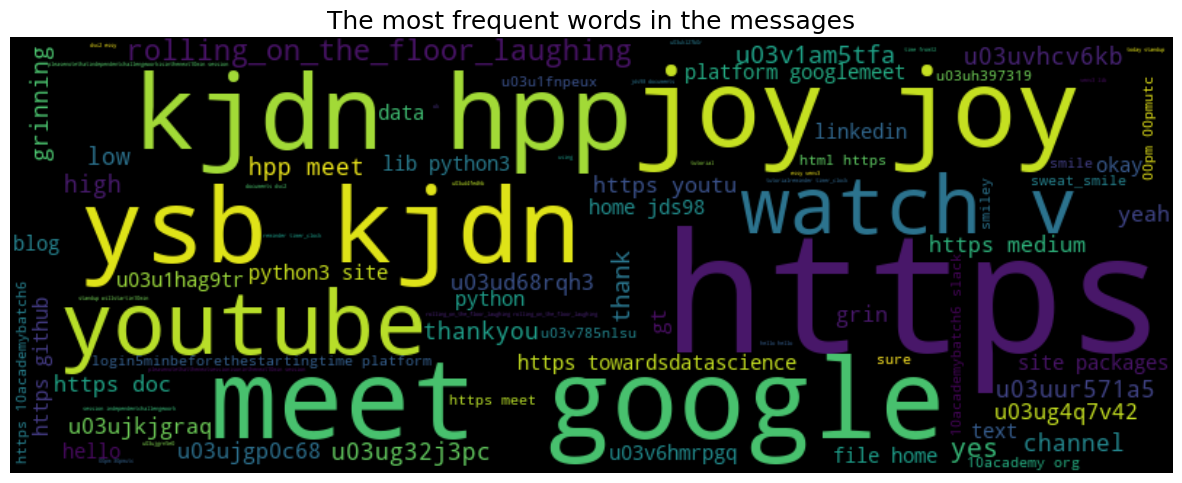

In [15]:
plt.figure(figsize=(15, 6))  # Adjusted figure size for better visualization
wordcloud = WordCloud(width=800, height=300, stopwords=STOPWORDS).generate(' '.join(slack_parser_df['msg_content'].values))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("The most frequent words in the messages", fontsize=18)
plt.show()